## ASSIH Esso Mèwè Jacques IS

### Projet IA : Détection Automatique de Genre pour la Carte d'Identité Nationale du Togo

#### Étape 1 : Préparation des Données

Charger le dataset (noms_prenoms.csv) contenant 

In [2]:
import pandas as pd

df = pd.read_csv('dataset_names.csv')
df['full_name'] = df['lastname'].str.strip() + ' ' + df['firstname'].str.strip()
df = df[['full_name', 'gender']]

Nettoyage des données

In [3]:
df.dropna(inplace=True) # Supprimer les valeurs manquantes
df['full_name'] = df['full_name'].str.lower().str.strip()  # Uniformiser la casse

Feature Engineering : Extraction du prénom (dernier mot de full_name)

In [4]:
df['prenom'] = df['full_name'].apply(lambda x: x.split()[-1])

Créer des features manuelles telles que

1. Longueur du prénom

In [5]:
df['longueur_prenom'] = df['prenom'].apply(len)

2. Terminaisons fréquentes (ex : 'a', 'e' pour féminin, 'ou', 'd’pour masculin).

In [6]:
df['termine_par_a'] = df['prenom'].apply(lambda x: 1 if x.endswith('a') else 0)
df['termine_par_e'] = df['prenom'].apply(lambda x: 1 if x.endswith('e') else 0)
df['termine_par_ou'] = df['prenom'].apply(lambda x: 1 if x.endswith('ou') else 0)
df['termine_par_d'] = df['prenom'].apply(lambda x: 1 if x.endswith('d') else 0)


3. Préfixes courants (ex : "Mohamed", "Aïssa").

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# Ajout de préfixes courants
prefixes_feminins = ['aïssa', 'adjo', 'ama', 'séna', 'afî']
prefixes_masculins = ['koffi', 'kouamé', 'mohamed', 'yao', 'komi']

df['prefixe_feminin'] = df['prenom'].apply(lambda x: 1 if any(x.startswith(p) for p in prefixes_feminins) else 0)
df['prefixe_masculin'] = df['prenom'].apply(lambda x: 1 if any(x.startswith(p) for p in prefixes_masculins) else 0)

# Vectorisation des prénoms (n-grammes de caractères)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
X_ngrams = vectorizer.fit_transform(df['prenom'])
ngrams_df = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())

# Concaténation de toutes les features
X = pd.concat([df[['longueur_prenom', 'termine_par_a', 'termine_par_e', 'termine_par_ou', 
                   'termine_par_d', 'prefixe_feminin', 'prefixe_masculin']], ngrams_df], axis=1)
y = df['gender']

#### Étape 2 : Séparation des Données

Séparation du dataset en Train/Test (70% / 30%)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Taille jeu d'entraînement :", len(X_train))
print("Taille jeu de test :", len(X_test))
print(f"Train set : {X_train.shape}, Test set : {X_test.shape}")

Taille jeu d'entraînement : 7000
Taille jeu de test : 3000
Train set : (7000, 870), Test set : (3000, 870)


#### Étape 3 : Entraînement du Modèle (Ensemble Learning)

1. Random Forest et XGBoost 
2. (Optionnel) Gradient Boosting
3. Entraînement des modèles sur le jeu d'entraînement.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialisation des modèles : Random Forest et XGBoost
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)


# Option Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)


# Entraînement des modèles
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Étape 4 : Évaluation des Performances

Calcul des métriques sur le jeu de test

- Accuracy
- Precision
- Recall
- F1-Score.
- Comparaison des performances des différents modèles.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred), 
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Comparaison des performances des deux modèles
rf_metrics = evaluate_model(rf, X_test, y_test)  # Random Forest
xgb_metrics = evaluate_model(xgb, X_test, y_test)  # XGBoost

print("Random Forest Metrics:", rf_metrics) 
print("XGBoost Metrics:", xgb_metrics)

Random Forest Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
XGBoost Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


#### Étape 5 : Optimisation (Bonus)

1. Hyperparamétrage avec GridSearchCV pour optimiser les paramètres.

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Test de différentes valeurs pour n_estimators
    'max_depth': [None, 10, 20],      # Test de différentes profondeurs max
    'min_samples_split': [2, 5]       # Test de différents seuils de split
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_ 

param_grid_xgb = {
    'n_estimators': [100, 200],       # Test de différentes valeurs
    'max_depth': [3, 6, 9],           # Test de différentes profondeurs
    'learning_rate': [0.01, 0.1]      # Test de différents taux d'apprentissage
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1')
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_ 

best_rf_metrics = evaluate_model(best_rf, X_test, y_test)
best_xgb_metrics = evaluate_model(best_xgb, X_test, y_test)

print("Optimized Random Forest Metrics:", best_rf_metrics)
print("Optimized XGBoost Metrics:", best_xgb_metrics)

Optimized Random Forest Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Optimized XGBoost Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


2. Feature Importance : Identification des features qui influencent le plus la prédiction.

In [12]:
rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_ 
}).sort_values('importance', ascending=False)

print("Top 10 Features par Importance:")
print(rf_importances.head(10))

Top 10 Features par Importance:
             feature  importance
2      termine_par_e    0.091203
1      termine_par_a    0.056288
312               ia    0.022150
500               ne    0.021995
353              ine    0.019293
0    longueur_prenom    0.017586
423               le    0.016247
397               ko    0.011491
663               sa    0.008437
699               su    0.008398


- Visualisation des Top 20 Features + Interprétation

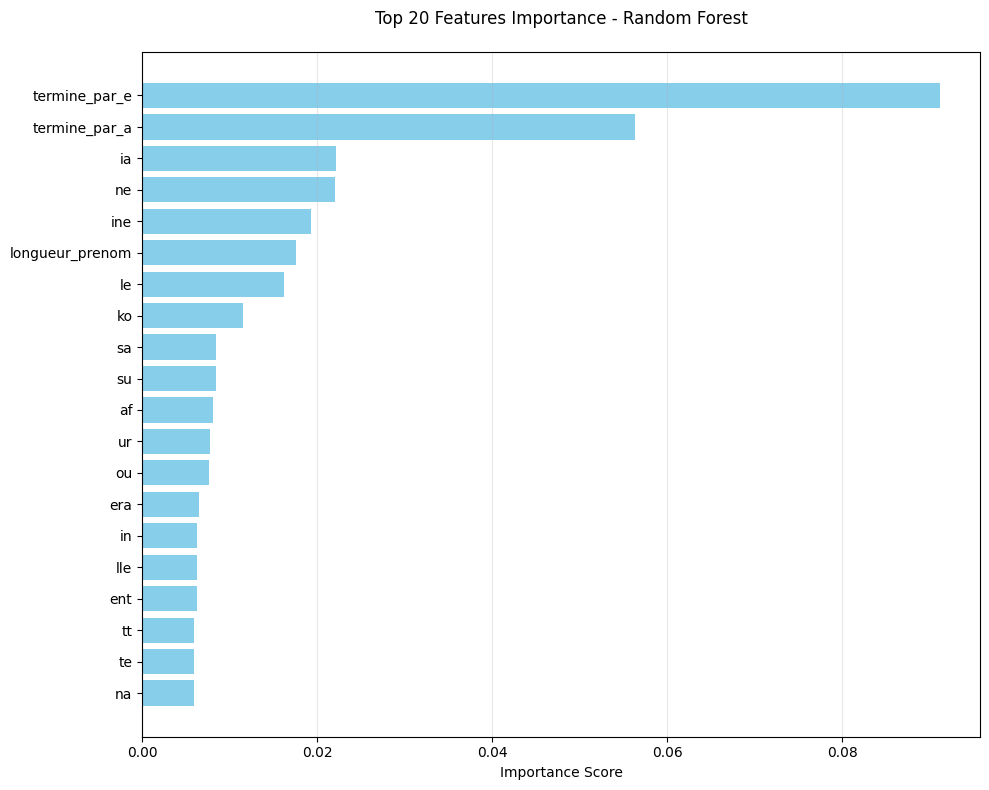


    Analyse pour Random Forest:
    Les features les plus importantes sont termine_par_e (la plus influente), 
    suivie par termine_par_a et ia.
    On observe que les terminaisons de prénoms et les préfixes semblent particulièrement discriminants. 


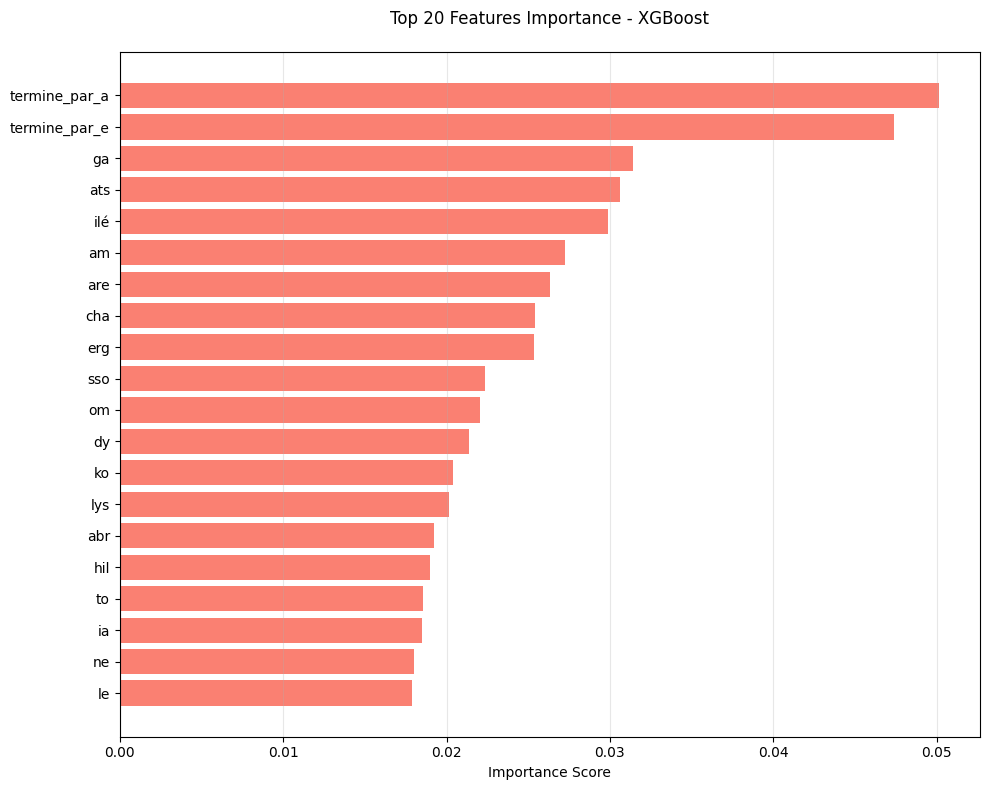


    Analyse pour XGBoost:
    Les features les plus importantes sont termine_par_a (la plus influente), 
    suivie par termine_par_e et ga.
    On observe que les terminaisons de prénoms et les préfixes semblent particulièrement discriminants. 

Comparaison globale:
Les deux modèles s'accordent généralement sur l'importance des motifs de caractères (n-grams)
mais diffèrent sur l'importance relative des features manuelles (comme la longueur du prénom).
Cette analyse peut guider la sélection de features pour de futurs modèles.


In [13]:
import matplotlib.pyplot as plt

def plot_top_features(importances, features, model_name, color):

    sorted_idx = importances.argsort()[-20:]  # Top 20 features seulement
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], color=color, align='center')
    plt.yticks(range(len(sorted_idx)), features[sorted_idx])
    plt.title(f"Top 20 Features Importance - {model_name}", pad=20)
    plt.xlabel("Importance Score")
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

    plt.show()
    print(f"""
    Analyse pour {model_name}:
    Les features les plus importantes sont {features[sorted_idx[-1]]} (la plus influente), 
    suivie par {features[sorted_idx[-2]]} et {features[sorted_idx[-3]]}.
    On observe que les terminaisons de prénoms et les préfixes semblent particulièrement discriminants. """)

plot_top_features(best_rf.feature_importances_, X.columns, "Random Forest", 'skyblue')
plot_top_features(best_xgb.feature_importances_, X.columns, "XGBoost", 'salmon')

# Comparaison
print("""
Comparaison globale:
Les deux modèles s'accordent généralement sur l'importance des motifs de caractères (n-grams)
mais diffèrent sur l'importance relative des features manuelles (comme la longueur du prénom).
Cette analyse peut guider la sélection de features pour de futurs modèles.""")


#### Étape 6 : Prédiction sur de Nouvelles Données

Une fonction predict_gender(nom_et_prenom) qui retourne :
- 0 si le modèle prédit Femme.
- 1 si le modèle prédit Homme.

In [14]:
def predict_gender(nom_et_prenom):

    try:
        nom_complet = str(nom_et_prenom).strip()
        prenom = nom_complet.split()[-1].lower()

        features = {
            'longueur_prenom': len(prenom),
            'termine_par_a': int(prenom.endswith('a')),
            'termine_par_e': int(prenom.endswith('e')),
            'termine_par_ou': int(prenom.endswith('ou')),
            'termine_par_d': int(prenom.endswith('d')),
            'prefixe_feminin': int(any(prenom.startswith(p) for p in prefixes_feminins)),
            'prefixe_masculin': int(any(prenom.startswith(p) for p in prefixes_masculins))
        }
        ngrams = vectorizer.transform([prenom]).toarray()
        ngrams_df = pd.DataFrame(ngrams, columns=vectorizer.get_feature_names_out())
        
        features_df = pd.DataFrame([features])
        full_features = pd.concat([features_df, ngrams_df], axis=1)
        full_features = full_features.reindex(columns=X.columns, fill_value=0)
        
        proba = best_xgb.predict_proba(full_features)[0]
        prediction = best_xgb.predict(full_features)[0]
        
        confiance = max(proba) * 100
        genre = "Homme" if prediction == 1 else "Femme"
        
        return f"{nom_complet} -> {prediction} ({genre}) [Confiance: {confiance:.1f}%]"
        
    except Exception as e:
        return f"{nom_complet} -> Erreur: {str(e)}"
    

- Test avec quelques noms et prenoms

In [16]:
print(predict_gender("KOKOU Ama"))
print(predict_gender("AKAKPO Juliette"))

print(predict_gender("DOUTI Ama"))
print(predict_gender("MENSAH Dové"))

print(predict_gender("KOKOU Mawuli"))
print(predict_gender("MAWUSSI Afi"))

print(predict_gender("YAOVI Gédéon"))
print(predict_gender("TCHALLA Jenifere"))

print(predict_gender("KODJO Merveille"))
print(predict_gender("SENA Helene"))

print(predict_gender("ROCK Koffi"))
print(predict_gender("KOSSIWA Ama"))

print(predict_gender("DOGBO Ruth"))

KOKOU Ama -> 0 (Femme) [Confiance: 90.6%]
AKAKPO Juliette -> 0 (Femme) [Confiance: 94.4%]
DOUTI Ama -> 0 (Femme) [Confiance: 90.6%]
MENSAH Dové -> 1 (Homme) [Confiance: 97.3%]
KOKOU Mawuli -> 1 (Homme) [Confiance: 94.3%]
MAWUSSI Afi -> 0 (Femme) [Confiance: 84.9%]
YAOVI Gédéon -> 1 (Homme) [Confiance: 90.7%]
TCHALLA Jenifere -> 0 (Femme) [Confiance: 84.4%]
KODJO Merveille -> 0 (Femme) [Confiance: 95.0%]
SENA Helene -> 0 (Femme) [Confiance: 99.0%]
ROCK Koffi -> 1 (Homme) [Confiance: 95.6%]
KOSSIWA Ama -> 0 (Femme) [Confiance: 90.6%]
DOGBO Ruth -> 1 (Homme) [Confiance: 90.3%]
